# Example interactions with code modules

In [1]:
import numpy as np
from qiskit import execute, Aer
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import *
import matplotlib.pyplot as plt
import logging
import time
import copy

from IPython.core.display import display, HTML
from IPython.display import IFrame
from pyvis import network as net

from plerco.pec_python.qec_code.rssc import RSSC
from plerco.pec_python.qec_circuit.rssc_circuit import RSSCCircuit
from plerco.pec_python.qec_decoder.rssc_decoder import RSSCDecoder

from plerco.pec_python.qec_code.hhc import HHC
from plerco.pec_python.qec_circuit.hhc_circuit import HHCCircuit
from plerco.pec_python.qec_decoder.hhc_decoder import HHCDecoder

from plerco.pec_python.qec_noise_model.paulinoisemodel import PauliNoiseModel
from plerco.pec_python.configuration.config import Config

logging.basicConfig(filename='output.log', filemode='w', level=logging.INFO)

def make_model(p):
    """Make a Pauli model for depolarizing noise."""
    pnm = PauliNoiseModel()
    pnm.add_operation("cx", {"ix": 1, "iy": 1, "iz": 1,
                             "xi": 1, "xx": 1, "xy": 1, "xz": 1,
                             "yi": 1, "yx": 1, "yy": 1, "yz": 1,
                             "zi": 1, "zx": 1, "zy": 1,
                             "zz": 1})
    pnm.add_operation("id", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("reset", {"x": 1})
    pnm.add_operation("measure", {"x": 1})
    pnm.add_operation("h", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("x", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("y", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("z", {"x": 1, "y": 1, "z": 1})
    pnm.add_operation("idm", {"x": 1, "y": 1, "z": 1})
    pnm.set_error_probability("cx", p)
    pnm.set_error_probability("id", p)
    pnm.set_error_probability("reset", p)
    pnm.set_error_probability("measure", p)
    pnm.set_error_probability("h", p)
    pnm.set_error_probability("x", p)
    pnm.set_error_probability("y", p)
    pnm.set_error_probability("z", p)
    pnm.set_error_probability("idm", p)
    return pnm

def run_circuit(qc, shots, model=None, seed=100):
    """Simulate a circuit with the stabilizer simulator.
    
    qc = QuantumCircuit to simulate
    shots = number of shots to run
    model = noise model to use, None if no noise
    seed = seed value for random number generator
    
    Return the dictionary of counts.
    """
    qasmsim = Aer.get_backend('qasm_simulator')
    if model is None:
        result = execute(qc, qasmsim, method="stabilizer", shots=shots,
                         optimization_level=0, seed_simulator=seed).result()
    else:
        result = execute(qc, qasmsim, 
                         noise_model=model.as_aer_noise_model(),
                         basis_gates=model.as_aer_noise_model().basis_gates,
                         method="stabilizer",
                         shots=shots,
                         optimization_level=0,
                         seed_simulator=seed).result()
    return result.get_counts(qc)

def sigma(p, shots):
    """Compute the sample standard deviation.
    
    p = Bernoulli parameter
    shots = number of samples
    
    Return the value.
    """
    return np.sqrt(p * (1-p)/float(shots-1))

def sim(circ, shots, p, decoder, code, model, basis, input_state):
    tic = time.perf_counter()
    counts_n = run_circuit(circ, shots, model)
    toc = time.perf_counter()
    print(f"simulate circuits in {toc - tic:0.4f} seconds")
    decoder.update_edge_weights(model)
    tic = time.perf_counter()
    failures = 0
    for (outcome, num) in counts_n.items():
        reversed_outcome = list(map(int, outcome[::-1]))  # convert to list of integers
        corrected_outcomes = decoder.process(reversed_outcome)
        if basis == 'z':
            fail = code.logical_x_error(corrected_outcomes)
        elif basis == 'x':
            fail = code.logical_z_error(corrected_outcomes)
        if input_state == '-':
            fail[0] = (fail[0] + 1) % 2
        if bool(fail[0]):
            failures += num
    toc = time.perf_counter()
    print(f"decode outcomes in {toc - tic:0.4f} seconds")
    pfail = float(failures)/float(shots)
    sig = sigma(pfail, shots)
    return pfail, sig

def scan_hhc(shots, pin, d, rounds, round_schedule, basis, input_state):
    pfails = []
    sigs = []
    print('scanning %d %d %s %s %s' % (d, rounds, round_schedule, basis, input_state))
    config = Config()
    config["code"]["d"] = d
    config["circuit"]["schedule"] = "heavy-hex"
    config["circuit"]["rounds"] = rounds
    config["circuit"]["round_schedule"] = round_schedule
    config["circuit"]["basis"] = basis
    config["circuit"]["input_state"] = input_state
    config["decoder"]["method"] = "matching_pymatching"
    code = HHC(config["code"]["d"])
    gen = HHCCircuit(code, config)
    circ = gen.syndrome_measurement()
    model = make_model(0.01)  # arbitrary p
    tic = time.perf_counter()
    decoder = HHCDecoder(code, circ, model, config)
    toc = time.perf_counter()
    print(f"construct decoder in {toc - tic:0.4f} seconds")
    for p in pin:
        model = make_model(p)
        print('running %d %f' % (shots, p))
        pf, s = sim(circ, shots, p, decoder, code, model, basis, input_state)
        pfails.append(pf)
        sigs.append(s)
    return pfails, sigs

def make_input_graph(decoding_graph):
    """Copy and adjust a decoding graph for display by pyviz.

    decoding_graph = input decoding graph
    Return networkx graph for display.
    """
    graph = copy.deepcopy(decoding_graph)
    # Make edge attributes serializable and add color and title
    for u, v, a in graph.edges(data=True):
        if "weight_poly" in a:
            a["weight_poly"] = str(a["weight_poly"])
            a["title"] = a["weight_poly"] + ", qubit=" + str(a["qubit_id"])
        else:
            a["title"] = str(a["weight"]) + ", qubit=" + str(a["qubit_id"])
        if a["measurement_error"] == 1:
            a["color"] = "green"
        else:
            a["color"] = "black"
    # Add size, title, and color node attributes
    for n, a in graph.nodes(data=True):
        if "is_boundary" in a and a["is_boundary"]:
            a["size"] = 30
        else:
            a["size"] = 50
        a["title"] = str(a["qubits"])  # visible on mouseover
        colors = ["red", "blue"]
        a["color"] = colors[a["time"] % len(colors)]
    return graph

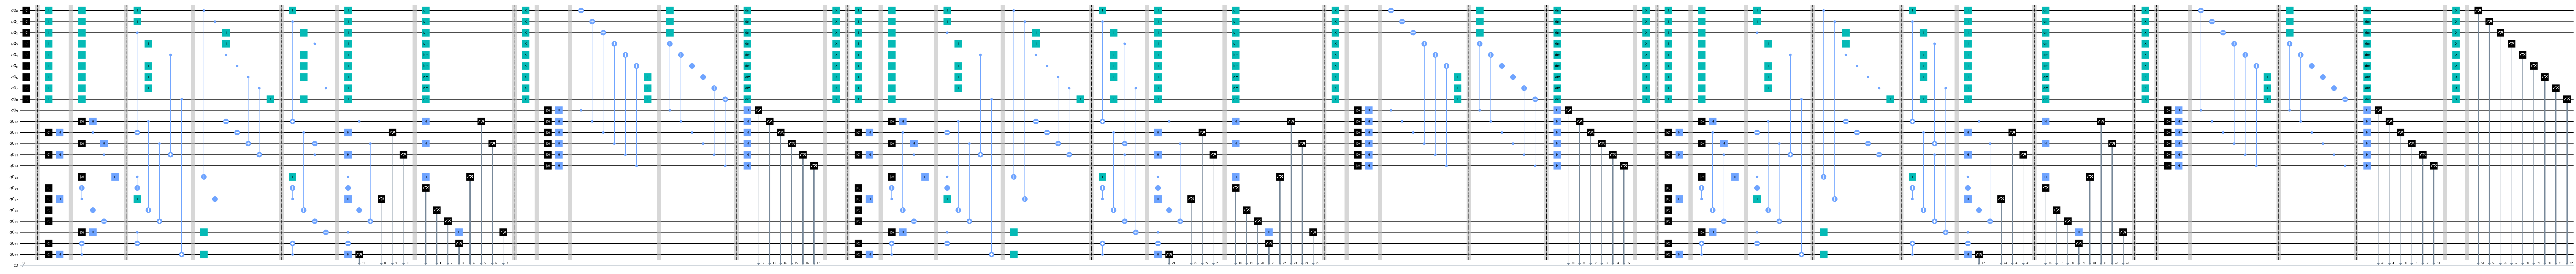

In [2]:
config = Config()
config["code"]["d"] = 3
config["circuit"]["schedule"] = "heavy-hex"
config["circuit"]["rounds"] = 3
config["circuit"]["round_schedule"] = 'zx'
config["circuit"]["basis"] = 'z'
config["circuit"]["input_state"] = '+'
config["circuit"]["logical_paulis"] = 'xx'
config["circuit"]["add_barriers"] = True  # default
config["circuit"]["add_idles"] = True  # default
config["circuit"]["distinct_measurement_idle"] = True
code = HHC(config["code"]["d"])
gen = HHCCircuit(code, config)
circ = gen.syndrome_measurement()
circ.draw(output="mpl", fold=1000)

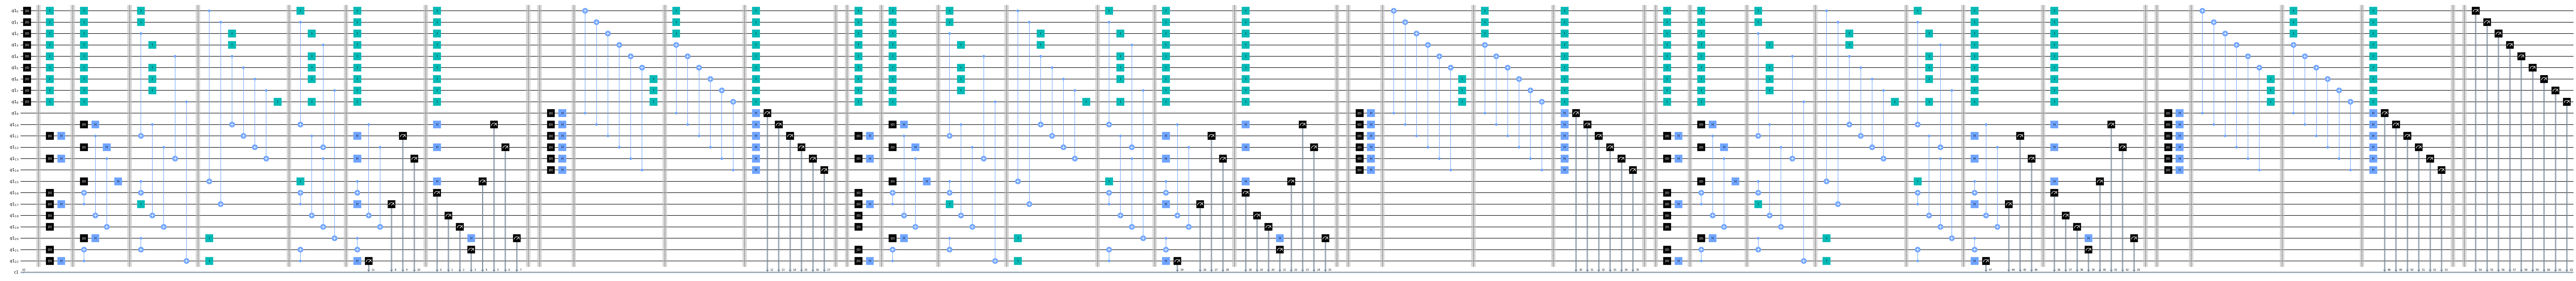

In [3]:
config = Config()
config["code"]["d"] = 3
config["circuit"]["schedule"] = "heavy-hex"
config["circuit"]["rounds"] = 3
config["circuit"]["round_schedule"] = 'zx'
config["circuit"]["basis"] = 'z'
config["circuit"]["input_state"] = '-'
config["circuit"]["logical_paulis"] = 'ii'
config["circuit"]["add_barriers"] = True  # default
config["circuit"]["add_idles"] = True  # default
config["circuit"]["distinct_measurement_idle"] = False
config["decoder"]["method"] = "matching_pymatching"
config["decoder"]["uniform"] = False  # default

# We need to define a noise model as well to construct the decoder
# Method #1: PauliNoiseModel interface
p = 0.001
model = PauliNoiseModel()
model.add_operation("cx", {"ix": 1, "iy": 1, "iz": 1,
                           "xi": 1, "xx": 1, "xy": 1, "xz": 1,
                           "yi": 1, "yx": 1, "yy": 1, "yz": 1,
                           "zi": 1, "zx": 1, "zy": 1,
                           "zz": 1})
model.add_operation("id", {"x": 1, "y": 1, "z": 1})
model.add_operation("reset", {"x": 1})
model.add_operation("measure", {"x": 1})
model.add_operation("h", {"x": 1, "y": 1, "z": 1})
model.add_operation("x", {"x": 1, "y": 1, "z": 1})
model.add_operation("y", {"x": 1, "y": 1, "z": 1})
model.add_operation("z", {"x": 1, "y": 1, "z": 1})
model.add_operation("idm", {"x": 1, "y": 1, "z": 1})
model.set_error_probability("cx", p)
model.set_error_probability("id", p)
model.set_error_probability("reset", p)
model.set_error_probability("measure", p)
model.set_error_probability("h", p)
model.set_error_probability("x", p)
model.set_error_probability("y", p)
model.set_error_probability("z", p)
model.set_error_probability("idm", p)

# Method #2: add to config, construct from dictionary
config["noise"]["cx"]["chan"] = {"ix": 1, "iy": 1, "iz": 1, "xi": 1, "xx": 1, "xy": 1, "xz": 1, "yi": 1, "yx": 1, "yy": 1, "yz": 1, "zi": 1, "zx": 1, "zy": 1, "zz": 1}
config["noise"]["h"]["chan"] = {"x": 1, "y": 1, "z": 1}
config["noise"]["s"]["chan"] = {"x": 1, "y": 1, "z": 1}
config["noise"]["id"]["chan"] = {"x": 1, "y": 1, "z": 1}
config["noise"]["idm"]["chan"] = {"x": 1, "y": 1, "z": 1}
config["noise"]["x"]["chan"] = {"x": 1, "y": 1, "z": 1}
config["noise"]["y"]["chan"] = {"x": 1, "y": 1, "z": 1}
config["noise"]["z"]["chan"] = {"x": 1, "y": 1, "z": 1}
config["noise"]["measure"]["chan"] = {"x": 1}
config["noise"]["reset"]["chan"] = {"x": 1}
config["noise"]["cx"]["p"] = p
config["noise"]["h"]["p"] = p
config["noise"]["s"]["p"] = p
config["noise"]["id"]["p"] = p
config["noise"]["idm"]["p"] = p
config["noise"]["x"]["p"] = p
config["noise"]["y"]["p"] = p
config["noise"]["z"]["p"] = p
config["noise"]["measure"]["p"] = p
config["noise"]["reset"]["p"] = p
model = PauliNoiseModel(config["noise"])

code = HHC(config["code"]["d"])
gen = HHCCircuit(code, config)
circ = gen.syndrome_measurement()
decoder = HHCDecoder(code, circ, model, config)
circ.draw(output="mpl", fold=1000)

In [4]:
g = net.Network(height="500px", width='100%', heading='', notebook=True)
g.barnes_hut()
graph = make_input_graph(decoder.g)
g.from_nx(graph)
g.show("ex.html")
IFrame(src='./ex.html', width=900, height=550)

In [9]:
pin = [0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
pfails, sigs = scan_hhc(10000, pin, 3, 3, 'zx', 'z', '+')
pfailsx, sigsx = scan_hhc(10000, pin, 3, 3, 'zx', 'x', '+')
print(pfails)
print(sigs)
print(pfailsx)
print(sigsx)

scanning 3 3 zx z +
construct decoder in 0.9552 seconds
running 10000 0.000500
simulate circuits in 6.8642 seconds
decode outcomes in 3.6225 seconds
running 10000 0.000600
simulate circuits in 6.7588 seconds
decode outcomes in 3.6813 seconds
running 10000 0.000700
simulate circuits in 6.8911 seconds
decode outcomes in 3.7092 seconds
running 10000 0.000800
simulate circuits in 7.0174 seconds
decode outcomes in 3.6610 seconds
running 10000 0.000900
simulate circuits in 7.1647 seconds
decode outcomes in 3.8083 seconds
scanning 3 3 zx x +
construct decoder in 1.0568 seconds
running 10000 0.000500
simulate circuits in 7.6518 seconds
decode outcomes in 3.6007 seconds
running 10000 0.000600
simulate circuits in 7.5281 seconds
decode outcomes in 3.5859 seconds
running 10000 0.000700
simulate circuits in 7.6520 seconds
decode outcomes in 3.6725 seconds
running 10000 0.000800
simulate circuits in 7.5487 seconds
decode outcomes in 3.7054 seconds
running 10000 0.000900
simulate circuits in 7.7534 

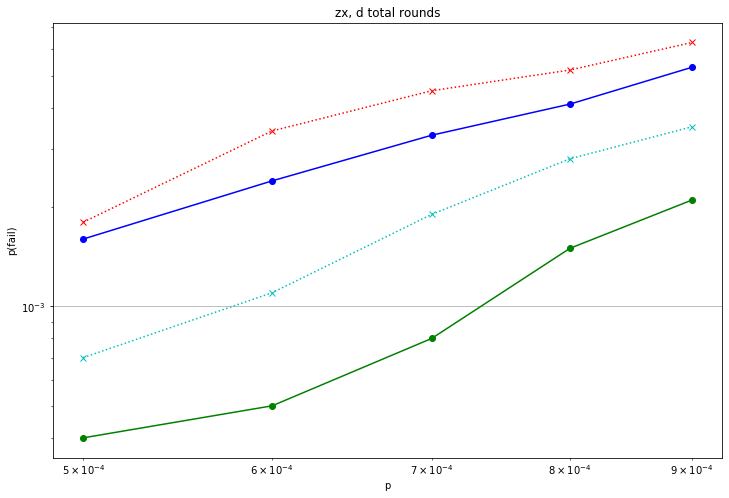

In [6]:
# d = 3
pin = [0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
pfails=[0.0016, 0.0024, 0.0033, 0.0041, 0.0053]
sigs=[0.0003996998573900168, 0.0004893341851888946, 0.000573536306077862, 0.0006390303873710533, 0.0007261155034651425]
pfailsx=[0.0018, 0.0034, 0.0045, 0.0052, 0.0063]
sigsx=[0.0004239032547609651, 0.0005821321909916843, 0.0006693428134970883, 0.0007192688890626907, 0.0007912607720346916]
# d = 5
pfails5=[0.0004, 0.0005, 0.0008, 0.0015, 0.0021]
sigs5=[0.00019996999474891224, 0.00022356206744392033, 0.00028274369029111855, 0.00038702710369934015, 0.0004577990366916466]
pfailsx5=[0.0007, 0.0011, 0.0019, 0.0028, 0.0035]
sigsx5=[0.00026449573871724277, 0.00033149658972438903, 0.00043549737748530665, 0.000528435354979622, 0.0005906012876620731]
plt.figure(figsize=(12,8))
plt.loglog(pin, pfails, 'bo-')
plt.loglog(pin, pfailsx, 'rx:')
plt.loglog(pin, pfails5, 'go-')
plt.loglog(pin, pfailsx5, 'cx:')
plt.grid(which='major',axis='both')
plt.title('zx, d total rounds')
plt.xlabel('p')
plt.ylabel('p(fail)')
plt.show()

In [3]:
A=RSSC(3)

In [7]:
A.logical_x

[[0, 3, 6]]

In [8]:
B=(1,2)

In [21]:
len(B)

2

In [32]:
a=list((1,11))

[0, 0]

In [33]:
a= np.asarray(a)

In [29]:
b = np.array([1,2])

In [34]:
c=a+5*b

In [35]:
c

array([ 6, 21])

In [37]:
%timeit a=np.zeros(2,dtype=int)

502 ns ± 7.44 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [38]:
%timeit a=np.array([0,0])

562 ns ± 4.69 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [39]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2020
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# Part of the QEC framework

class Manifold:
    def __init__(self, dim):
        self.dim=dim

In [41]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2020
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# Part of the QEC framework

from abc import abstractclassmethod
from qiskit.exceptions import QiskitError

#from qiskit_qec.geometry.manifold import Manifold

class TwoManifold(Manifold):
    def __init__(self):
        dim=2
        super().__init__(dim=2)
    
    @abstractclassmethod
    def ison(self, point):
        pass
    

In [47]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2020
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# Part of the QEC framework

from math import cos, sin
import numpy as np

from qiskit.exceptions import QiskitError

#from qiskit_qec.geometry.two_manifold import TwoManifold

class Plane(TwoManifold):
    def __init__(self):
        super().__init__()

    def ison(self, point):
        # Qick check that point is on the 
        if point.shape==(2,) and len(point)==2:
            return True
        else:
            return False

    @staticmethod
    def rotate(theta, vector):
        theta = np.deg2rad(theta)
        rot = Plane.rot_matrix(theta)
        return np.dot(rot, vector)

    @staticmethod
    def rot_matrix(theta):
        return np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

In [111]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2020
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# Part of the QEC framework

import numpy as np

from qiskit.exceptions import QiskitError

class GeometryBounds:
    """A simple Bounding Box class for an AABB in Rn
    """
    def __init__(self, center=None, size=None, dim=None) -> None:

        if center is None:
            if size is None:
                if dim is None:
                    center = [0,0,0]
                    size = [0,0,0]
                else:
                    center = np.zeros(dim)
                    size = np.zeros(dim)
            else:
                raise QiskitError("Both center and size must be spefified togther or not at all")

        self.center = np.array(center)
        self.size = np.array(size)
        
        assert self.center.shape == (self.center.size,), "Center not correct shape"
        assert self.size.shape == (self.size.size,), "Size not correct shape"
        
        self.min = self.center - self.size/2
        self.max = self.center + self.size/2

    def contains(self, point):
        if np.all(point-self.min) and np.all(self.max-point):
            return True
        else:
            return False

    def set_min_max(self,min_point, max_point):
        min_point = np.array(min_point)
        max_point = np.array(max_point)

        assert min_point.shape == (min_point.size,), "Min point not correct shape"
        assert max_point.shape == (max_point.size,), "Max point not correct shape"
        assert min_point.size == max_point.size, "min and max vectors must be the same dimension"

        self.min = min_point
        self.max= max_point
        self.center = (self.min + self.max)/2
        self.size =  2*(self.center-self.min)

    def combine(bounds1, bounds2):
        new_min = np.minimum(bounds1.min, bounds2.min)
        new_max = np.maximum(bounds1.max, bounds2.max)
        bounds = GeometryBounds()
        bounds.set_min_max(new_min, new_max)

        return bounds

    @staticmethod
    def bounding_box_from_line(point1, point2):
        new_min = np.minimum(point1, point2)
        new_max = np.maximum(point1, point2)

        bounds = GeometryBounds()
        bounds.set_min_max(new_min, new_max)

        return bounds


In [109]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2020
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# Part of the QEC framework

import numpy as np

#from qiskit_qec.geometry.plane import Plane
#from qiskit_qec.geometry.bounds import GeometryBounds

from qiskit.exceptions import QiskitError


class Shape:
    """This class is used to store a boundary shape on a given manifold that is used to
    select sublattices. 
    
    """
    def __init__(self, points, lines, indices=None):
        self.points = points
        self.lines = lines
        if indices is not None:
            self.indices = indices
        else:
            self.indices = list(range(len(self.points)))

        self.bounds = self.bounding_box_from_lines()

    def bounding_box_from_lines(self):
        line = self.lines[0]
        start = self.points[line[0]]
        finish = self.points[line[1]]
        bounds = GeometryBounds.bounding_box_from_line(start, finish)
        for line in self.lines:
            bounds2 = GeometryBounds.bounding_box_from_line(self.points[line[0]], self.points[line[1]])
            bounds = GeometryBounds.combine(bounds,bounds2)
        return bounds

    @classmethod
    def square(cls, 
        origin, 
        direction, 
        length, 
        manifold,
        dtype=int):

        """Create a square (2d) shape on the 2-manifold.

        The square has one corner placed at the origin (origin must be on the plane). The the
        square is defined as the path following heading in the direction <direction> towards the 
        next corner of length <length>. The proceeding to the next corner and so on. 

        Args:
            origin ([coordinate]): a coordinate on the plane
            direction ([vector]): vector describing the direction of the second corner
            length ([real]): length of the side of the square
            manifold ([TwoManifold]): 2-manifold
            dtype ([dtype], optional): Date type of coordinate entries. Defaults to int.

        Returns:
            [Shape]: Shape object describing a square of length <length> in the manifold <manifold>
        """

        origin = np.asarray(origin)
        direction = np.asarray(direction)

        return cls.rect(
            origin=origin, 
            direction=direction, 
            length1=length, 
            length2=length,
            manifold=manifold,
            dtype=dtype)

    @classmethod
    def rect(cls, 
        origin, 
        direction, 
        length1, 
        length2, 
        manifold,
        dtype=int):

        """Create a rectangle on a manifold

                    r2
                    o
                /      \
         r3  o          \
              \          o r1
               \       /
                  o
              r0=origin

        direction (r0 to r1)
        length1 = length(r0,r1)
        length2 = length(r1,r2)

        Args:
            origin ([type]): [description]
            direction ([type]): [description]
            length1 ([type]): [description]
            length2 ([type]): [description]
            dtype ([type], optional): [description]. Defaults to int.

        Raises:
            QiskitError: [description]
        """         

        assert(isinstance(origin, np.ndarray))
        assert(isinstance(direction, np.ndarray))

        assert length1>0 and length2>0, "Rectangle lengths must be positive"
        assert manifold.ison(origin), f"{origin} must be on the surface if the manifold"

        if isinstance(manifold, Plane):
            zero_origin = np.zeros(2,dtype=dtype)
            r0 = origin.astype(dtype)
            r1 = origin + length1 * direction
            r1 = r1.astype(int)
            direction = Plane.rotate(theta=90, vector=direction)
            r2 = r1 + length2 * direction
            r2 = r2.astype(int)
            direction = Plane.rotate(theta=90, vector=direction)
            r3 = r2 + length1 * direction
            r3 = r3.astype(int)
            
            points = [r0,r1,r2,r3]
            lines = [[0,1],[1,2],[2,3],[3,0]]

            return cls(points, lines)

        else:
            raise QiskitError(f"Manifold {manifold} not yet supported")



In [116]:
d=3
manifold = Plane()
shape = Shape.square(origin=(0,-1), direction=(1,1), length=d-1, manifold=manifold, dtype=int)

In [117]:
import copy

In [118]:
f = copy.copy(shape.bounds)

In [123]:
f.min = shape.bounds.min

In [124]:
f.min

array([-2, -1])

In [74]:
a=a-[4,1]

In [125]:
a=np.array([1,2,3])

In [126]:
b = a.copy()

In [127]:
b

array([1, 2, 3])

In [78]:
a.shape

(3,)

In [79]:
a.size

3

In [80]:
a.shape ==(a.size,)

True

In [128]:
a

array([1, 2, 3])

In [129]:
b=1

In [133]:
b+=1

In [136]:
b=b+1

In [137]:
a = np.array([0,1])
b = np.array([1,0])

In [138]:
x = [a,b]

In [139]:
x

[array([0, 1]), array([1, 0])]

In [140]:
a[0]=10

In [141]:
x

[array([10,  1]), array([1, 0])]

In [142]:
h = [x,x,x,x]

In [143]:
h

[[array([10,  1]), array([1, 0])],
 [array([10,  1]), array([1, 0])],
 [array([10,  1]), array([1, 0])],
 [array([10,  1]), array([1, 0])]]

In [144]:
a[0]=22

In [145]:
h

[[array([22,  1]), array([1, 0])],
 [array([22,  1]), array([1, 0])],
 [array([22,  1]), array([1, 0])],
 [array([22,  1]), array([1, 0])]]

In [150]:
h=list(range(100000))

In [149]:
h.remove(10000)

In [152]:
a=[1]
for i in a[1:]:
    print("Hi")